In [1]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from collections import Counter
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import random
import pickle as pkl
from tqdm import tqdm_notebook
import matplotlib.pylab as plt
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
os.chdir("/Users/Colin/Google Drive/nyu/nlp_dsga_1011/hw1/aclImdb/")

In [3]:
train_pos_dir = "train/pos/"
train_neg_dir = "train/neg/"
test_pos_dir = "test/pos/"
test_neg_dir = "test/neg/"

In [4]:
# function to read in text from dir and create label list
def read_files_to_list(path, target):
    text_list = []
    files = glob.glob(path + "*.txt") 
    target_list = [target] * len(files)
    for i in range(len(files)):
        with open(files[i]) as f: 
            text_list += [f.read()]
    return text_list, target_list

In [5]:
# read in train, test data and create labels
train_pos_text, train_pos_labels = read_files_to_list(train_pos_dir, 1)
train_neg_text, train_neg_labels = read_files_to_list(train_neg_dir, 0)
test_pos_text, test_pos_labels = read_files_to_list(test_pos_dir, 1)
test_neg_text, test_neg_labels = read_files_to_list(test_neg_dir, 0)

In [6]:
# concat pos, neg data
# train, val data
t_v_text = train_pos_text + train_neg_text
t_v_labels = train_pos_labels + train_neg_labels
# test data
test_text = test_pos_text + test_neg_text
test_labels = test_pos_labels + test_neg_labels

In [7]:
# shuffling train, val
random.seed(39) # for reproducibility
t_v_zipped = list(zip(t_v_text, t_v_labels))
random.shuffle(t_v_zipped)
t_v_text, t_v_labels = zip(*t_v_zipped)
t_v_labels = np.array(t_v_labels)

# splitting train, val
train_text = t_v_text[:20000]
train_labels = np.array(t_v_labels[:20000])
val_text = t_v_text[20000:]
val_labels = np.array(t_v_labels[20000:])

In [8]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

In [9]:
# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']


In [10]:
#def tokenize_stop_words(sent):
#  tokens = tokenizer(sent)
#  return [token.text.lower() for token in tokens if (token.text not in (punctuations or STOP_WORDS))]
#tokens = tokenize_stop_words(u'Apple is looking at buying U.K. startup for $1 billion')
#print (tokens)
def tokenize_stop_words(parsed):
        return [token.text.lower() for token in parsed if (token.text not in (punctuations or STOP_WORDS))]

In [11]:
# def tokenize_no_cuts(sent):
#   tokens = tokenizer(sent)
#   return [token.text.lower() for token in tokens]
# tokens = tokenize_no_cuts(u'Apple is looking at buying U.K. startup for $1 billion')
# print (tokens)
def tokenize_no_cuts(parsed):
    return [token.text.lower() for token in parsed]

In [12]:
def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

In [13]:
def tokenize_dataset(dataset, scheme):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []
    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = scheme(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [14]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_text, lower_case_remove_punc)

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_text, lower_case_remove_punc)

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_text, lower_case_remove_punc)

Tokenizing val data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Tokenizing test data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Tokenizing train data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [15]:
# make n-grams for n= 1-4
def tokens_to_ngrams(n, tokens):
    ngrams = [" ".join(tokens[i:i+n]) for i in list(range(len(tokens)-n+1))]
    ngrams
    return(ngrams)

In [16]:
def get_ngram_token_list(n, tokens) :
    token_list = []
    for i in range(n):
        ngrams = tokens_to_ngrams(i+1, tokens)
        token_list.append(ngrams)
    token_list = [i for sublist in token_list for i in sublist]
    return(token_list)

In [17]:
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print(get_ngram_token_list(1, tokens))

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']


In [18]:
# dumping pickles
#pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))
#pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))
#pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
#pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

In [19]:
#train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
#all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
#
#val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
#test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [20]:
max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [21]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5723 ; token jess
Token jess; token id 5723


In [22]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [23]:
MAX_SENTENCE_LENGTH = 200

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list o newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_labels)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [25]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [33]:
#for epoch in range(num_epochs):
#    for i, (data, lengths, labels) in enumerate(train_loader):
#        model.train()
#        data_batch, length_batch, label_batch = data, lengths, labels
#        optimizer.zero_grad()
#        outputs = model(data_batch, length_batch)
#        loss = criterion(outputs, label_batch)
#        loss.backward()
#        optimizer.step()
#        # validate every 100 iterations
#        if i > 0 and i % 100 == 0:
#            # validate
#            val_acc = test_model(val_loader, model)
#            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
#                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

Epoch: [1/10], Step: [101/625], Validation Acc: 79.54
Epoch: [1/10], Step: [201/625], Validation Acc: 83.38
Epoch: [1/10], Step: [301/625], Validation Acc: 85.6
Epoch: [1/10], Step: [401/625], Validation Acc: 86.02


KeyboardInterrupt: 

In [26]:
print(len(all_train_tokens))
print(len(train_data_tokens))
print(len(val_data_tokens))
print(len(test_data_tokens))

4815350
20000
5000
25000


In [27]:
def plot_training_curve (emb_dim, label_id, vocab = id2token, learning_rate = 0.01, n=1,
                            max_vocab_size = 10000, optim_type = 'adam', anneal_rate = 1.0, 
                            num_epochs = 5, plot_gap = 50):
    model = BagOfWords(len(vocab), emb_dim)
    criterion = torch.nn.CrossEntropyLoss()
    if optim_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optim_type == "sgd":
        optimizer = torch.optim.sgd(model.parameters(), lr=learning_rate)

    
    y = []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            if i >= 0 and i % plot_gap == 0:
                # validate
                val_acc = test_model(val_loader, model)
                #print(val_acc)
                y += [val_acc]
                #print(i)
    print(val_acc)
    x = np.arange(0, len(y))
    plt.plot(x, y)
    plt.xticks(np.arange(0,(625/plot_gap) * (num_epochs +1), (625/plot_gap)), np.arange(0,num_epochs+1))
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    

86.7


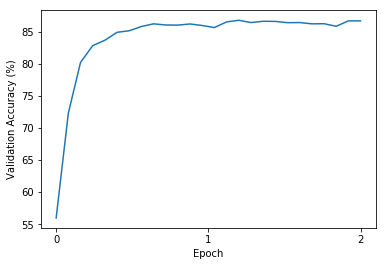

In [57]:
plot_training_curve(100, "test")

In [28]:
# build token tables for :
# tokenization schemes (no changes, original, orig + stop words)
# ngrams 1-4 (orig+ stop words)
# max_vocab_size 200, 500, 1k, 10k, 15k, 30k, 50k, 100k (orig+stop, 4grams)

In [29]:
# store different tokenization schemes in dictionary
tokenization_scheme_dict = {'lower_no_punc':{}, 'lower_no_punc_stop':{}, 'lower_only' : {}}

In [30]:
# lowercase, no puncuation tokens
tokenization_scheme_dict['lower_no_punc']['val'], _ = tokenize_dataset(val_text, lower_case_remove_punc)
tokenization_scheme_dict['lower_no_punc']['test'], _ = tokenize_dataset(test_text, lower_case_remove_punc)
tokenization_scheme_dict['lower_no_punc']['train'], _ = tokenize_dataset(train_text, lower_case_remove_punc)
tokenization_scheme_dict['lower_no_punc']['all'] = list(itertools.chain(*tokenization_scheme_dict['lower_no_punc']['train']))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [31]:
# lowercase no puncuation or stop tokens
tokenization_scheme_dict['lower_no_punc_stop']['val'], _ = tokenize_dataset(val_text, tokenize_stop_words)
tokenization_scheme_dict['lower_no_punc_stop']['test'], _ = tokenize_dataset(test_text, tokenize_stop_words)
tokenization_scheme_dict['lower_no_punc_stop']['train'], _ = tokenize_dataset(train_text, tokenize_stop_words)
tokenization_scheme_dict['lower_no_punc_stop']['all'] = list(itertools.chain(*tokenization_scheme_dict['lower_no_punc_stop']['train']))


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [32]:
# lowercase only
tokenization_scheme_dict['lower_only']['val'], _ = tokenize_dataset(val_text, tokenize_no_cuts)
tokenization_scheme_dict['lower_only']['test'], _ = tokenize_dataset(test_text, tokenize_no_cuts)
tokenization_scheme_dict['lower_only']['train'], _ = tokenize_dataset(train_text, tokenize_no_cuts)
tokenization_scheme_dict['lower_only']['all'] = list(itertools.chain(*tokenization_scheme_dict['lower_only']['train']))


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [33]:
# for each set of tokens in dictionary create 1-4 ngram lists
ngram_dict = {'lower_no_punc':{'n1':{}, 'n2':{}, 'n3':{}, 'n4':{}},
             'lower_no_punc_stop':{'n1':{}, 'n2':{}, 'n3':{}, 'n4':{}},
             'lower_only':{'n1':{}, 'n2':{}, 'n3':{}, 'n4':{}}}

In [ ]:
n = 1
for key1 in ngram_dict:
        ngram_dict[key1]['n1']['train'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['train']]
        print('done train : {}'.format(key1))
        ngram_dict[key1]['n1']['val'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['val']]
        print('done val: {}'.format(key1))
        ngram_dict[key1]['n1']['test'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['test']]
        print('done test: {}'.format(key1))
        ngram_dict[key1]['n1']['all'] = list(itertools.chain(*ngram_dict[key1]['n1']['train']))
        print('done all: {}'.format(key1))

In [34]:
# loop through dict inserting ngrams tokens
# only use best tokenization scheme
key1 = 'lower_no_punc_stop'
n = 1
for key2 in ngram_dict[key1]:
    ngram_dict[key1][key2]['train'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['train']]
    print('done train : {}'.format(n))
    ngram_dict[key1][key2]['val'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['val']]
    print('done val : {}'.format(n))
    ngram_dict[key1][key2]['test'] = [get_ngram_token_list(n,(item)) for item in tokenization_scheme_dict[key1]['test']]
    print('done test : {}'.format(n))
    ngram_dict[key1][key2]['all'] = list(itertools.chain(*ngram_dict[key1][key2]['train']))
    print('done all : {}'.format(n))
    n += 1 

done train : 1
done val : 1
done test : 1
done all : 1
done train : 2
done val : 2
done test : 2
done all : 2
done train : 3
done val : 3
done test : 3
done all : 3
done train : 4
done val : 4
done test : 4
done all : 4


In [36]:
#pkl.dump(ngram_dict, open("colins_tokens_n1_only.p", "wb"))
pkl.dump(ngram_dict, open("colins_tokens_2.p", "wb"))

OSError: [Errno 22] Invalid argument

In [80]:
val_acc = test_model(test_loader, model)
print("test acc: {}".format(val_acc))

test acc: 85.216


84.86


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


85.02
84.54


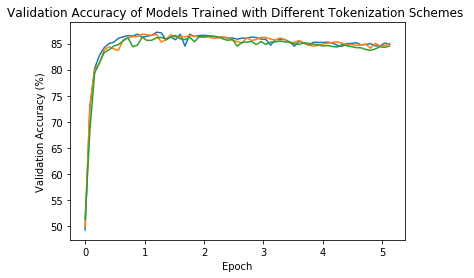

In [64]:
# plot tokenization schemes using n1
for key in ngram_dict:
    token2id, id2token = build_vocab(ngram_dict[key]['n1']['all'])
    train_data_indices = token2index_dataset(ngram_dict[key]['n1']['train'])
    val_data_indices= token2index_dataset(ngram_dict[key]['n1']['val'])
    #test_data_indices = token2index_dataset(ngram_dict[key1]['n1']['test'])
    
    train_dataset = NewsGroupDataset(train_data_indices, train_labels)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_labels)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    #skip test data for now
    #test_dataset = NewsGroupDataset(test_data_indices, test_labels)
    #test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
    #                                           batch_size=BATCH_SIZE,
    #                                           collate_fn=newsgroup_collate_func,
    #                                           shuffle=False)
    plot_training_curve(100, str(key), num_epochs=5)
    plt.legend()
    plt.title("Validation Accuracy of Models Trained with Different Tokenization Schemes ")

In [ ]:
# now vary ngrams
n_list = ['n1', 'n2', 'n3', 'n4']
for key in n_list:
    token2id, id2token = build_vocab(ngram_dict['lower_no_punc_stop'][key]['all'])
    train_data_indices = token2index_dataset(ngram_dict['lower_no_punc_stop'][key]['train'])
    val_data_indices= token2index_dataset(ngram_dict['lower_no_punc_stop'][key]['val'])
    #test_data_indices = token2index_dataset(ngram_dict[key1]['n1']['test'])
    
    train_dataset = NewsGroupDataset(train_data_indices, train_labels)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_labels)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    #skip test data for now
    #test_dataset = NewsGroupDataset(test_data_indices, test_labels)
    #test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
    #                                           batch_size=BATCH_SIZE,
    #                                           collate_fn=newsgroup_collate_func,
    #                                           shuffle=False)
    plot_training_curve(100, str(key), num_epochs=5)
    plt.legend()
    plt.title("Validation Accuracy of Models Trained with Different Ngrams")

84.74


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [ ]:
# now vary vocab size
max_vocab_size_list = [100, 1000, 10000, 50000, 60000]
for size in max_vocab_size_list:
    token2id, id2token = build_vocab(ngram_dict['lower_no_punc_stop']['n?']['all'], max_vocab_size = size)
    train_data_indices = token2index_dataset(ngram_dict['lower_no_punc_stop']['n?']['train'])
    val_data_indices= token2index_dataset(ngram_dict['lower_no_punc_stop']['n?']['val'])
    #test_data_indices = token2index_dataset(ngram_dict[key1]['n1']['test'])
    
    train_dataset = NewsGroupDataset(train_data_indices, train_labels)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_labels)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    #skip test data for now
    #test_dataset = NewsGroupDataset(test_data_indices, test_labels)
    #test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
    #                                           batch_size=BATCH_SIZE,
    #                                           collate_fn=newsgroup_collate_func,
    #                                           shuffle=False)
    plot_training_curve(100, label_id = str(size))
plt.legend()
plt.title("Validation Accuracy of Models Trained with Different Vocab Size ")

In [ ]:
# now vary embedding size:
embd_size_list = [10, 100, 500, 1000]
for embd_size in embd_size_list:
    token2id, id2token = build_vocab(ngram_dict['lower_no_punc_stop']['n?']['all'], max_vocab_size = ???)
    train_data_indices = token2index_dataset(ngram_dict['lower_no_punc_stop']['n?']['train'])
    val_data_indices= token2index_dataset(ngram_dict['lower_no_punc_stop']['n?']['val'])
    #test_data_indices = token2index_dataset(ngram_dict[key1]['n1']['test'])
    
    train_dataset = NewsGroupDataset(train_data_indices, train_labels)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_labels)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)
    plot_training_curve(embd_size, label_id = str(embd_size), max_vocab_size = ?????)
plt.legend()
plt.title("Validation Accuracy of Models Trained with Different Embedding Sizes")   

In [ ]:
# now vary optimizer:
plot_training_curve(embd_size, label_id = 'adam', optim_type = 'adam')
plot_training_curve(embd_size, label_id = 'sgd', optim_type = 'sgd')
plt.title("Validation Accuracy of Models Trained with Different Optimizer Types")   

In [ ]:
# now vary learning rate:
lr_list = [0.001, 0.01, 0.1]
for rate in lr_list:
    plot_training_curve(embd_size, label_id = str(rate), optim_type = 'adam????', learning_rate = rate)
plt.title("Validation Accuracy of Models Trained with Different Learning Rates")   

In [ ]:
# now vary annealing:
